In [170]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
import chromadb
import json
import pandas as pd
from PIL import Image
from chromadb.utils.data_loaders import ImageLoader
from weavingtools.annotation_tools import soft_wrap_text
from weavingtools.embedding_tools import SigLIPEmbedder
from weavingtools.weaving_tools import *
import scipy.spatial as sp
import ipyannotations.generic
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
sns.set()

In [172]:
def plot_record_pair(record_pair):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
    
    for i in range(2):
        record = collection_df[collection_df.record_id==record_pair[i]]
        img_path = record.img_path.values[0]
        description = soft_wrap_text(record.description.values[0])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(description, fontsize = 18)
        axes[i].axis('off')
         
    plt.show()

In [173]:
checkpoint = 'google/siglip-base-patch16-224'

siglip_embedder = SigLIPEmbedder(checkpoint)

client = chromadb.PersistentClient(path="ce_comms_db")

data_loader = ImageLoader()

collection_db = client.get_or_create_collection(name="ce_comms_db", 
                                             metadata={"hnsw:space": "cosine"},
                                             embedding_function=siglip_embedder, 
                                             data_loader=data_loader
                                            )

collection_df = pd.read_csv('data/communications_data.csv')
collection_df.shape[0], collection_db.count()

(6020, 22026)

# Retrieval Annotation

In [137]:
from weavingtools.annotation_tools import plot_by_record
import requests
import time
from pathlib import Path
from io import BytesIO

In [138]:
out_path = Path('annotations')
out_path.mkdir(exist_ok=True)

In [123]:
plt.ioff() # turn off default inline plotting

filters = {
    "$and": [
        {
            "input_modality": {
                "$eq": "image"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}

# modality = "image"
# filters = {"input_modality": modality}
top_n = 20
annotator = 'NK'

In [128]:
query = 'a valve'
results = collection_db.query(query_texts=[query],where=filters, n_results=top_n)

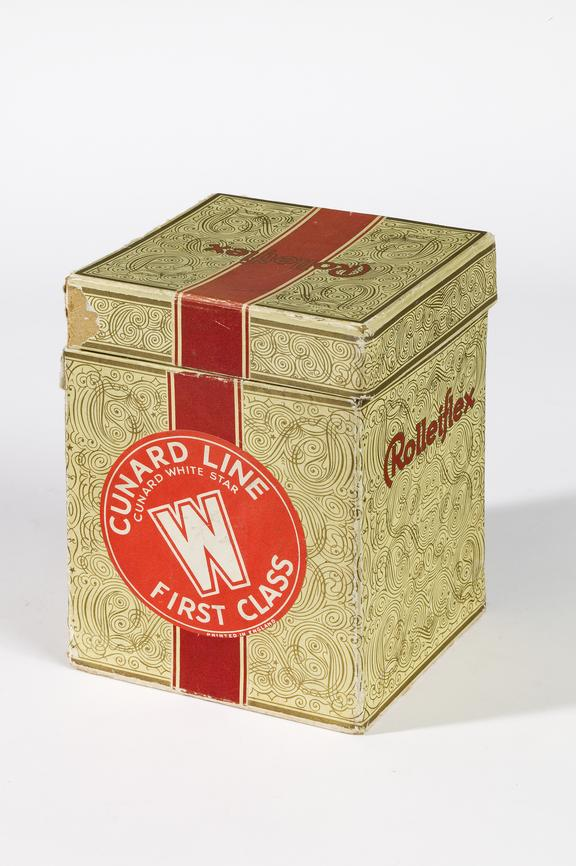

In [94]:
idx = 350
record = collection_df.iloc[idx]
results = collection_db.query(query_images=[record.img_path],n_results=top_n, where=filters) # 
Image.open(record.img_path)

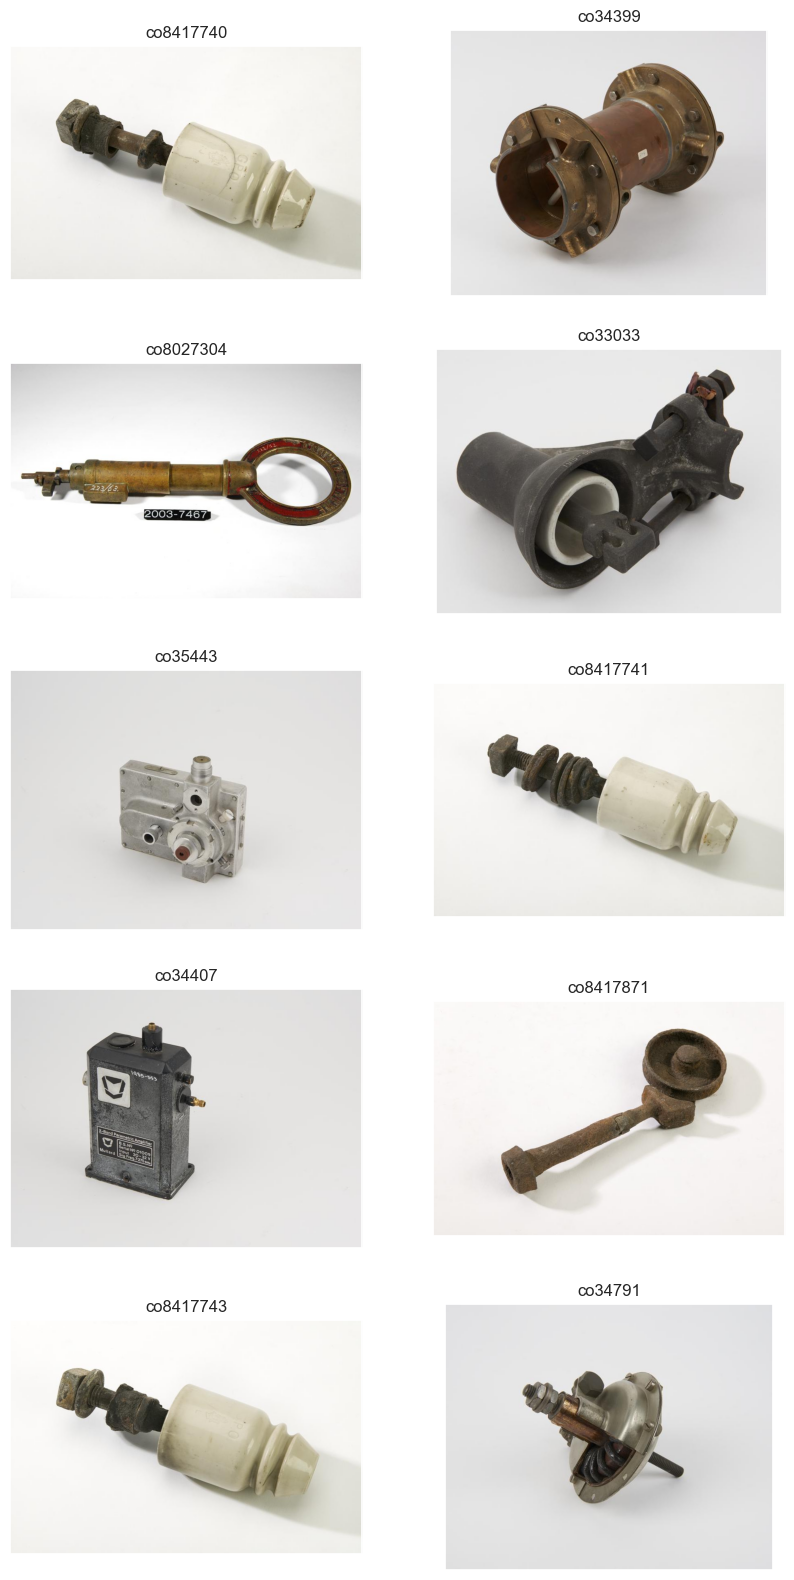

In [129]:
query_df = plot_query_results(results, collection_df,source='img_path')

## Annotate

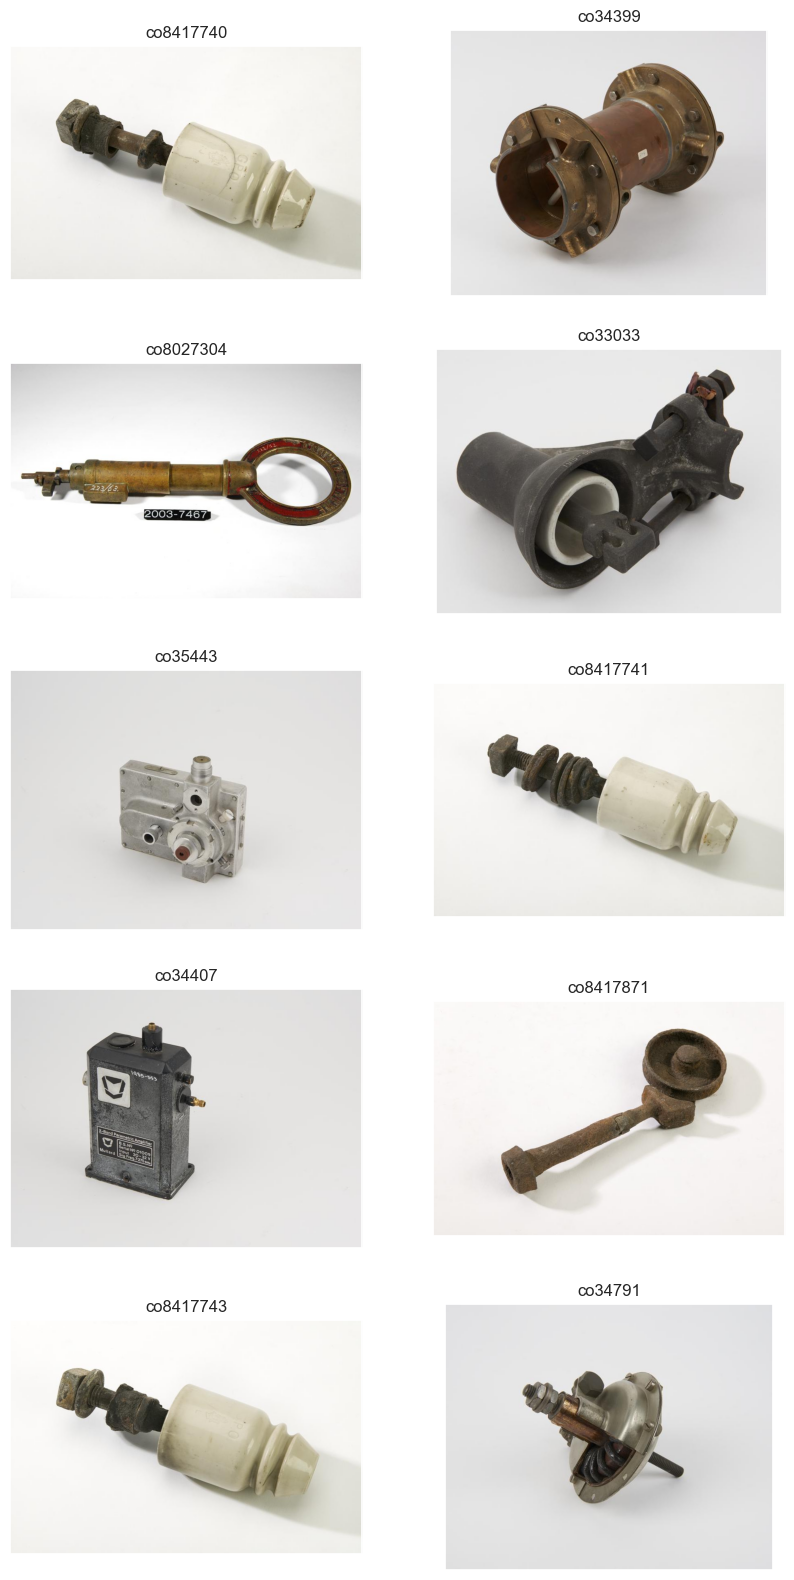

20

In [131]:
query_df = plot_query_results(results, collection_df)
inputs = list(query_df.to_records()); len(inputs)

In [132]:
labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['relevant', 'not relevant'], allow_freetext=False,
        display_function=plot_by_record)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(inputs.pop(0))
    except IndexError:
        print("Finished.")
        
widget.on_submit(store_annotations)
widget.display(inputs.pop(0))
widget

ClassLabeller(children=(Box(children=(Output(layout=Layout(margin='auto', min_height='50px')),), layout=Layout…

In [ ]:
query_df['labels'] = labels[:top_n]
query_df['query'] = query
query_df['modality'] = modality
query_df.to_csv(out_path / f'{annotator}_{time.time()}.csv')

# Link Annotation

In [174]:
annotator = 'KB'
num_annotations = 10
coll1, coll2 = 'smg','nms'
modality1, modality2 = 'image', 'image'
percentile = 99.5
randomize = True

In [175]:
edges, image_similarities, inputs = get_edges(collection_db,coll1,coll2, modality1, modality2, percentile); len(edges)

31440

In [176]:
if randomize:
    random.shuffle(edges)
img_pairs = edges[:num_annotations]
to_annotate = img_pairs.copy()

labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['link', 'no link'], allow_freetext=True,
        display_function=plot_record_pair)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(img_pairs.pop(0))
    except IndexError:
        print("Finished.")
widget.on_submit(store_annotations)
widget.display(img_pairs.pop(0))
widget


ClassLabeller(children=(Box(children=(Output(layout=Layout(margin='auto', min_height='50px')),), layout=Layout…

In [177]:
annotations_df = pd.DataFrame(to_annotate, columns=['coll1','coll2'])
annotations_df['labels'] = labels[:num_annotations]
for varname, var in [('coll1_name',coll1), ('coll2_name',coll2), ('modality1',modality1), ('modality2',modality2)]:
    annotations_df[varname] = var
annotations_df.to_csv(out_path / f'{annotator}_{time.time()}')

ValueError: Length of values (0) does not match length of index (10)

# Fin.

In [107]:
# filter_smg = {
#     "$and": [
#         {
#             "input_modality": {
#                 "$eq": modality1
#             }
#         },
#         {
#             "collection": {
#                 "$eq" : coll1
#             }
#         }
#     ]
# }


# smg_data = collection_db.get(
#                 where=filter_smg,
#                 include=['embeddings','metadatas']

#                     )

# filter_nms = {
#     "$and": [
#         {
#             "input_modality": {
#                 "$eq": modality2
#             }
#         },
#         {
#             "collection": {
#                 "$eq" : coll2
#             }
#         }
#     ]
# }

# nms_data = collection_db.get(
#                 where=filter_nms,
#                 include=['embeddings','metadatas']
#             )

In [ ]:
 if plot_matrix:
        sns.set(rc={'figure.figsize':(15.7,12.27)})
        sns.heatmap(image_similarities, cmap= sns.cm.rocket_r)

In [150]:
image_similarities = compute_similarities(inputs, percentile)

In [159]:
#smg_node_ids = list(np.where(image_similarities.sum(axis=1) > 0)[0])
#nms_node_ids = list(np.where(image_similarities.sum(axis=0) > 0)[0])

mapping1 = {i:j for i,j in zip(range(len(inputs['coll1_emb'])),inputs['coll1_rids'])}
mapping2 = {i:j for i,j in zip(range(len(inputs['coll2_emb'])),inputs['coll2_rids'])}

edges = [(mapping1[i],mapping2[j]) for i,j in zip(*np.where(image_similarities > 0))]

In [151]:
image_similarities.shape

(4675, 1345)

In [157]:
sns.set(rc={'figure.figsize':(15.7,12.27)})
sns.heatmap(image_similarities, cmap= sns.cm.rocket_r)

<Axes: >

In [156]:
plt.ion()

In [154]:
smg_ids = smg_data['ids']
nms_ids = nms_data['ids']

smg_rids = [record['record_id'] for record in smg_data['metadatas']]
nms_rids = [record['record_id'] for record in nms_data['metadatas']]

smg_emb = np.matrix(smg_data['embeddings'])
nms_emb = np.matrix(nms_data['embeddings'])
image_similarities = 1 - sp.distance.cdist(smg_emb,nms_emb, 'cosine')

threshold = np.percentile(image_similarities.reshape(-1), percentile) ; threshold

image_similarities[image_similarities >= threshold] = 1
image_similarities[image_similarities < threshold] = 0

sns.set(rc={'figure.figsize':(15.7,12.27)})

sns.heatmap(image_similarities, cmap= sns.cm.rocket_r)

<Axes: >

In [109]:
#image_similarities.sum(axis=1).sum()/(image_similarities.shape[0]*image_similarities.shape[1])

In [110]:
smg_node_ids = list(np.where(image_similarities.sum(axis=1) > 0)[0])
nms_node_ids = list(np.where(image_similarities.sum(axis=0) > 0)[0])

smg_mapping = {i:j for i,j in zip(range(len(smg_data['embeddings'])),smg_rids)}
nms_mapping = {i:j for i,j in zip(range(len(nms_data['embeddings'])),nms_rids)}

edges = [(smg_mapping[i],nms_mapping[j]) for i,j in zip(*np.where(image_similarities > 0))]

In [112]:
to_annotate = edges[:num_annotations]

In [113]:
print(len(edges))

31440


In [118]:
labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['link', 'no link'], allow_freetext=True,
        display_function=plot_record_pair)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(img_pairs.pop(0))
    except IndexError:
        print("Finished.")
widget.on_submit(store_annotations)
widget.display(img_pairs.pop(0))
widget


ClassLabeller(children=(Box(children=(Output(layout=Layout(margin='auto', min_height='50px')),), layout=Layout…

In [ ]:
annotations_df